In [1]:
!wget https://raw.githubusercontent.com/bmontea1/bme_data_science/master/weatherHistory.csv; \

--2019-10-07 16:52:18--  https://raw.githubusercontent.com/bmontea1/bme_data_science/master/weatherHistory.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16294377 (16M) [text/plain]
Saving to: ‘weatherHistory.csv.7’

weatherHistory.csv. 100%[===================>]  15.54M  96.4MB/s    in 0.2s    

2019-10-07 16:52:18 (96.4 MB/s) - ‘weatherHistory.csv.7’ saved [16294377/16294377]



In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import sklearn.linear_model as lm
import statsmodels as sm
import statsmodels.formula.api as smf

In [3]:
dat = pd.read_csv('weatherHistory.csv')
print(type(dat))
dat.head(10)

<class 'pandas.core.frame.DataFrame'>


,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.
5,2006-04-01 05:00:00.000 +0200,Partly Cloudy,rain,9.222222,7.111111,0.85,13.9587,258.0,14.9569,0.0,1016.66,Partly cloudy throughout the day.
6,2006-04-01 06:00:00.000 +0200,Partly Cloudy,rain,7.733333,5.522222,0.95,12.3648,259.0,9.9820,0.0,1016.72,Partly cloudy throughout the day.
7,2006-04-01 07:00:00.000 +0200,Partly Cloudy,rain,8.772222,6.527778,0.89,14.1519,260.0,9.9820,0.0,1016.84,Partly cloudy throughout the day.
8,2006-04-01 08:00:00.000 +0200,Partly Cloudy,rain,10.822222,10.822222,0.82,11.3183,259.0,9.9820,0.0,1017.37,Partly cloudy throughout the day.
9,2006-04-01 09:00:00.000 +0200,Partly Cloudy,rain,13.772222,13.772222,0.72,12.5258,279.0,9.9820,0.0,1017.22,Partly cloudy throughout the day.


Note: 'rain' here is defined as formation of water droplets 0.05mm in diameter (Source: https://climate.ncsu.edu/edu/PrecipTypes), some of which never make it to the ground. Snow is the same but never melted from formation in the sky, which happens less often.

In [4]:
pres = dat['Pressure (millibars)']
hum = dat['Humidity']

dattt = dat.drop(dat[hum <= 0.1].index)
datt = dattt.drop(dat[pres <= 869].index)
print('Removed Data Points due to 0 Humidity is:', len(dat[hum <= 0.1].index))
print('Removed Data Points due to 0 Pressure is:', len(dat[pres <= 869].index))
print('Total Data Points before removing', len(dat))
print('Total Data Points after removing', len(datt))
prec = np.asarray(datt['Precip Type'])
weather = np.asarray(datt[['Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Pressure (millibars)', 'Visibility (km)']])

temp = np.asarray(datt[['Temperature (C)']])
ntemp = temp[0:-1]
humi = np.asarray(datt[['Humidity']])
nhumi = humi[0:-1]
wind = np.asarray(datt[['Wind Speed (km/h)']])
nwind = wind[0:-1]
pres = np.asarray(datt[['Pressure (millibars)']])
npres = pres[0:-1]
visi = np.asarray(datt[['Visibility (km)']])
nvisi = visi[0:-1]

rainy = []
for i in range(len(prec)):
  if prec[i] == 'rain':
    rainy.append(1)
  else:
    rainy.append(0)

nextrain = rainy[1:]    
nowweat = weather[0:-1]
lastrain = rainy[-1]
lastweat = weather[-1:]
nrain = np.asarray(nextrain)      



Removed Data Points due to 0 Humidity is: 22
Removed Data Points due to 0 Pressure is: 1288
Total Data Points before removing 96453
Total Data Points after removing 95143


Text(0.5, 1.0, 'Rain as a function of Visibility')

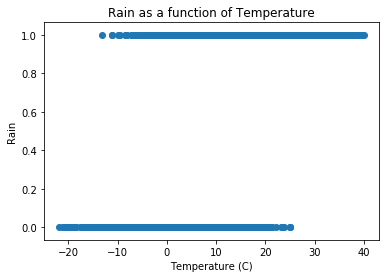

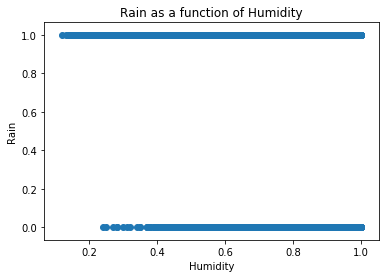

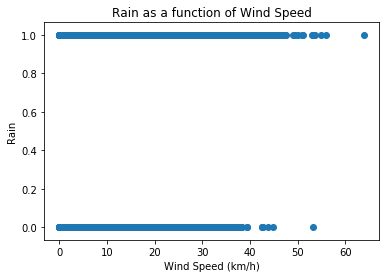

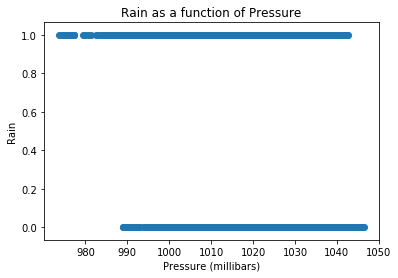

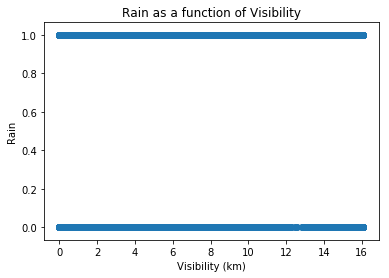

In [5]:
plt.figure(1)
plt.scatter(ntemp, nrain)
plt.xlabel('Temperature (C)')
plt.ylabel('Rain')
plt.title('Rain as a function of Temperature')

plt.figure(2)
plt.scatter(nhumi, nrain)
plt.xlabel('Humidity')
plt.ylabel('Rain')
plt.title('Rain as a function of Humidity')

plt.figure(3)
plt.scatter(nwind, nrain)
plt.xlabel('Wind Speed (km/h)')
plt.ylabel('Rain')
plt.title('Rain as a function of Wind Speed')

plt.figure(4)
plt.scatter(npres, nrain)
plt.xlabel('Pressure (millibars)')
plt.ylabel('Rain')
plt.title('Rain as a function of Pressure')

plt.figure(5)
plt.scatter(nvisi, nrain)
plt.xlabel('Visibility (km)')
plt.ylabel('Rain')
plt.title('Rain as a function of Visibility')

Prediction: Rain: As Temp goes up, Humidity goes up, Wind up, Pressure down, visibility down

This model is able to avoid being overfitted due to the sheer volume of data being trained relative to the number of parameters (~90,000 data points, 6 parameters)

In [6]:
nweather = sm.tools.add_constant(nowweat)

trainFraction = .9
np.random.seed(0)
sample = np.random.uniform(size = len(nrain)) < trainFraction

xtraining = nweather[sample]
xtesting = nweather[~sample]
ytraining = nrain[sample]
ytesting = nrain[~sample]

print('Training data points:', len(xtraining))
print('Testing data points:', len(xtesting))

fit = sm.discrete.discrete_model.Logit(ytraining, xtraining).fit()

B0, BT, BH, BW, BP, BV = fit.params
print('b0 = ', B0, ' bTemp = ', BT, ' bHum = ', BH, 'bWind = ', BW, 'bPres = ', BP, 'bVis = ', BV)

Training data points: 85614
Testing data points: 9528
Optimization terminated successfully.
         Current function value: 0.112210
         Iterations 10
b0 =  2.407375289992787  bTemp =  0.6987701563768447  bHum =  2.73125922417899 bWind =  0.005744630628645644 bPres =  -0.005055623064470497 bVis =  0.05363434554324529


Predictions as expected, except for visibility

Log-odds ratio most sensitive to change in humidity, followed by temperature, then visibility, wind speed, and finally pressure

In [7]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                85614
Model:                          Logit   Df Residuals:                    85608
Method:                           MLE   Df Model:                            5
Date:                Mon, 07 Oct 2019   Pseudo R-squ.:                  0.6872
Time:                        16:52:26   Log-Likelihood:                -9606.8
converged:                       True   LL-Null:                       -30716.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4074      2.329      1.034      0.301      -2.157       6.972
x1             0.6988      0.008     85.846      0.000       0.683       0.715
x2             2.7313      0.211     12.928      0.000       2.317       3.145
x3             0.0057      0.003      1.854      0.064      -0.000       0.012
x4            -0.0051      0.002     -2.283      0.022      -0.009      -0.001
x5             0.0536      0.005     10.618      0.000       0.044       0.064
==============================================================================

Possibly complete quasi-separation: A fraction 0.45 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [8]:
lw = sm.tools.add_constant(lastweat, has_constant='add')
lastday = fit.predict(lw)

tTesting = (fit.predict(xtesting))
tTTesting = tTesting.tolist()
ytest = ytesting.tolist()   
fpr, tpr, threshold = skl.metrics.roc_curve(ytesting, tTesting)
 
roc_auc = skl.metrics.auc(fpr, tpr)
spec = []
for i in range(len(fpr)):
  spec.append(1 - fpr[i])  
  
ypredd = []
tT = list(tTesting)

accuracy = []  
for i in range(len(threshold)):
  fre = []
  acc = []
  for j in range(len(tTTesting)):
    if tTTesting[j] > threshold[i]:
      fre.append(1)
    else:
      fre.append(0)
    if fre[j] == ytest[j]:
      acc.append(1)
    else:
      acc.append(0)
  accuracy.append(np.mean(acc))    
   
maxacc = max(accuracy)
print('Maximum Accuracy attainable from the model:', maxacc)
accind = accuracy.index(maxacc)
threshG = threshold[accind]
print('Threshold to attain maximum accuracy:', threshG)
sens = tpr[accind]
print('True Positive Rate (Sensitivity) with selected Threshold:', sens)
specc = spec[accind]
print('True Negative Rate (Specificity) with selected Threshold:', specc)    

print('The Model predicts rain on the last day:', (lastday > threshG)[0])
print('It actually rains on the last day:', lastrain == 1)
  


Maximum Accuracy attainable from the model: 0.9725020990764064
Threshold to attain maximum accuracy: 0.531790610400764
True Positive Rate (Sensitivity) with selected Threshold: 0.988252046991812
True Negative Rate (Specificity) with selected Threshold: 0.8510445049954587
The Model predicts rain on the last day: True
It actually rains on the last day: True


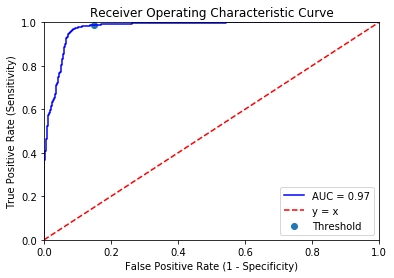

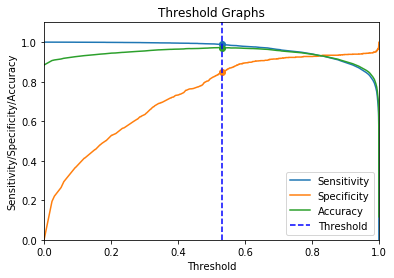

In [9]:
plt.figure(1)
plt.title('Receiver Operating Characteristic Curve')
plt.plot(fpr, tpr, 'b')
plt.scatter(1-specc, sens)
plt.plot([0, 1], [0, 1],'r--')
plt.legend(['AUC = %0.2f' % roc_auc, 'y = x', 'Threshold'])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1 - Specificity)')

plt.figure(2)
plt.plot(threshold, tpr)
plt.scatter(threshG, tpr[accind])
plt.plot(threshold, spec)
plt.scatter(threshG, spec[accind])
plt.plot(threshold, accuracy)
plt.scatter(threshG, accuracy[accind])
plt.plot([threshG, threshG], [0, 1.1], 'b--')
plt.title('Threshold Graphs')
plt.xlim([0, 1])
plt.ylim([0, 1.1])
plt.ylabel('Sensitivity/Specificity/Accuracy')
plt.xlabel('Threshold')
plt.legend(['Sensitivity', 'Specificity', 'Accuracy', 'Threshold'])
plt.show()